# Projeto de Clusterização de Dados

Projeto da disciplina de Algoritmos de Inteligência Artificial para Clusterização, primeira disciplina do Módulo 4 - Clusterização de Dados, sendo esse o último módulo da [Pós-Graduação MIT em Inteligência Artificial, Machine Learning e Deep Learning](https://posgraduacao.infnet.edu.br/ead/pos-graduacao-machine-learning-deep-learning-curso-deep-learning/) do [Instituto Infnet](https://www.infnet.edu.br/infnet/instituto/).

O projeto envolve análise exploratória, pré-processamento, aplicação dos algoritmos K-Means, K-Medoids, Hierárquico, DBSCAN e respostas teóricas sobre os métodos utilizados, atendendo aos requisitos solicitados em seu [enunciado](https://lms.infnet.edu.br/moodle/mod/assign/view.php?id=461649).

Desenvolvido pela aluna [Ingrid Coda](https://infnet.online/meembers/ingrid_codahotmail-com-2/) e disponibilizado no repositório [mit-ia-clusterizacao](https://github.com/ingridcoda/mit-ia-clusterizacao) no GitHub.

# Bloco 1 — Infraestrutura e requirements.txt

In [1]:
import sys, platform, os, json
from pathlib import Path
print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("Platform:", platform.platform())
try:
    import importlib.metadata as im
except Exception:
    import importlib_metadata as im
pkgs = [
    "numpy","pandas","scikit-learn","scipy","matplotlib","seaborn",
    "nbformat","scikit-learn-extra","pyclustering","kaggle"
]
lines = []
for p in pkgs:
    try:
        v = im.version(p)
        print(f"{p}=={v}")
        lines.append(f"{p}=={v}")
    except Exception:
        print(f"{p} não instalado")
pins = {
    "scikit-learn":">=1.2", "numpy":">=1.26", "pandas":">=2.2", "scipy":">=1.10",
    "matplotlib":">=3.6", "seaborn":">=0.12", "nbformat":">=5.7",
    "scikit-learn-extra":">=0.3.0", "pyclustering":">=0.10.1.2", "kaggle":">=1.5"
}
for p in pkgs:
    if p in pins and not any(l.startswith(p+"==") for l in lines):
        lines.append(f"{p}{pins[p]}")
Path(".").joinpath("requirements.txt").write_text("\n".join(lines))
print("\nrequirements.txt gerado.")

print("\nConteúdo de requirements.txt:")
with open("requirements.txt","r") as f:
    print(f.read())

Python executable: /Users/ingridcoda/infnet/clusterizacao/pd/mit-ia-clusterizacao/.venv/bin/python
Python version: 3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-26.0.1-arm64-arm-64bit-Mach-O
numpy==2.3.5
pandas==2.3.3
scikit-learn==1.7.2
scipy==1.16.3
matplotlib==3.10.7
seaborn==0.13.2
nbformat==5.10.4
scikit-learn-extra==0.3.0
pyclustering==0.10.1.2
kaggle==1.8.2

requirements.txt gerado.

Conteúdo de requirements.txt:
numpy==2.3.5
pandas==2.3.3
scikit-learn==1.7.2
scipy==1.16.3
matplotlib==3.10.7
seaborn==0.13.2
nbformat==5.10.4
scikit-learn-extra==0.3.0
pyclustering==0.10.1.2
kaggle==1.8.2


In [2]:
!pip install --upgrade pip && pip install -r requirements.txt

# Bloco 2 — Carregamento robusto do dataset

In [3]:
import pandas as pd
def load_country_dataset():
    data_dir = Path("data")
    data_dir.mkdir(exist_ok=True)
    candidate_names = ["Country-data.csv", "country-data.csv", "country_data.csv"]
    for name in candidate_names:
        p = data_dir / name
        if p.exists():
            df = pd.read_csv(p)
            print("Carregado local:", p)
            return df, p
    try:
        from kaggle import api
        print("Baixando do Kaggle...")
        api.dataset_download_files(
            "rohan0301/unsupervised-learning-on-country-data",
            path=str(data_dir), unzip=True
        )
        for name in candidate_names:
            p = data_dir / name
            if p.exists():
                df = pd.read_csv(p)
                print("Baixado via Kaggle:", p)
                return df, p
    except Exception as e:
        print("Falha Kaggle:", e)
        raise FileNotFoundError(
            "Arquivo 'Country-data.csv' não encontrado em data/ e a API do Kaggle falhou. "
            "Coloque o CSV original na pasta data/."
        )
df, df_path = load_country_dataset()
print("Shape:", df.shape)
print(df.head(3))
expected_cols = {'country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp'}
assert expected_cols.issubset(set(df.columns)), f"Colunas inesperadas. Esperado conter: {expected_cols}"

Baixando do Kaggle...
Dataset URL: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data
Baixado via Kaggle: data/Country-data.csv
Shape: (167, 10)
       country  child_mort  exports  health  imports  income  inflation  \
0  Afghanistan        90.2     10.0    7.58     44.9    1610       9.44   
1      Albania        16.6     28.0    6.55     48.6    9930       4.49   
2      Algeria        27.3     38.4    4.17     31.4   12900      16.10   

   life_expec  total_fer  gdpp  
0        56.2       5.82   553  
1        76.3       1.65  4090  
2        76.5       2.89  4460  


# Bloco 3 — EDA: contagem de países, boxplots e histogramas

Número de países distintos: 167
Colunas numéricas: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']


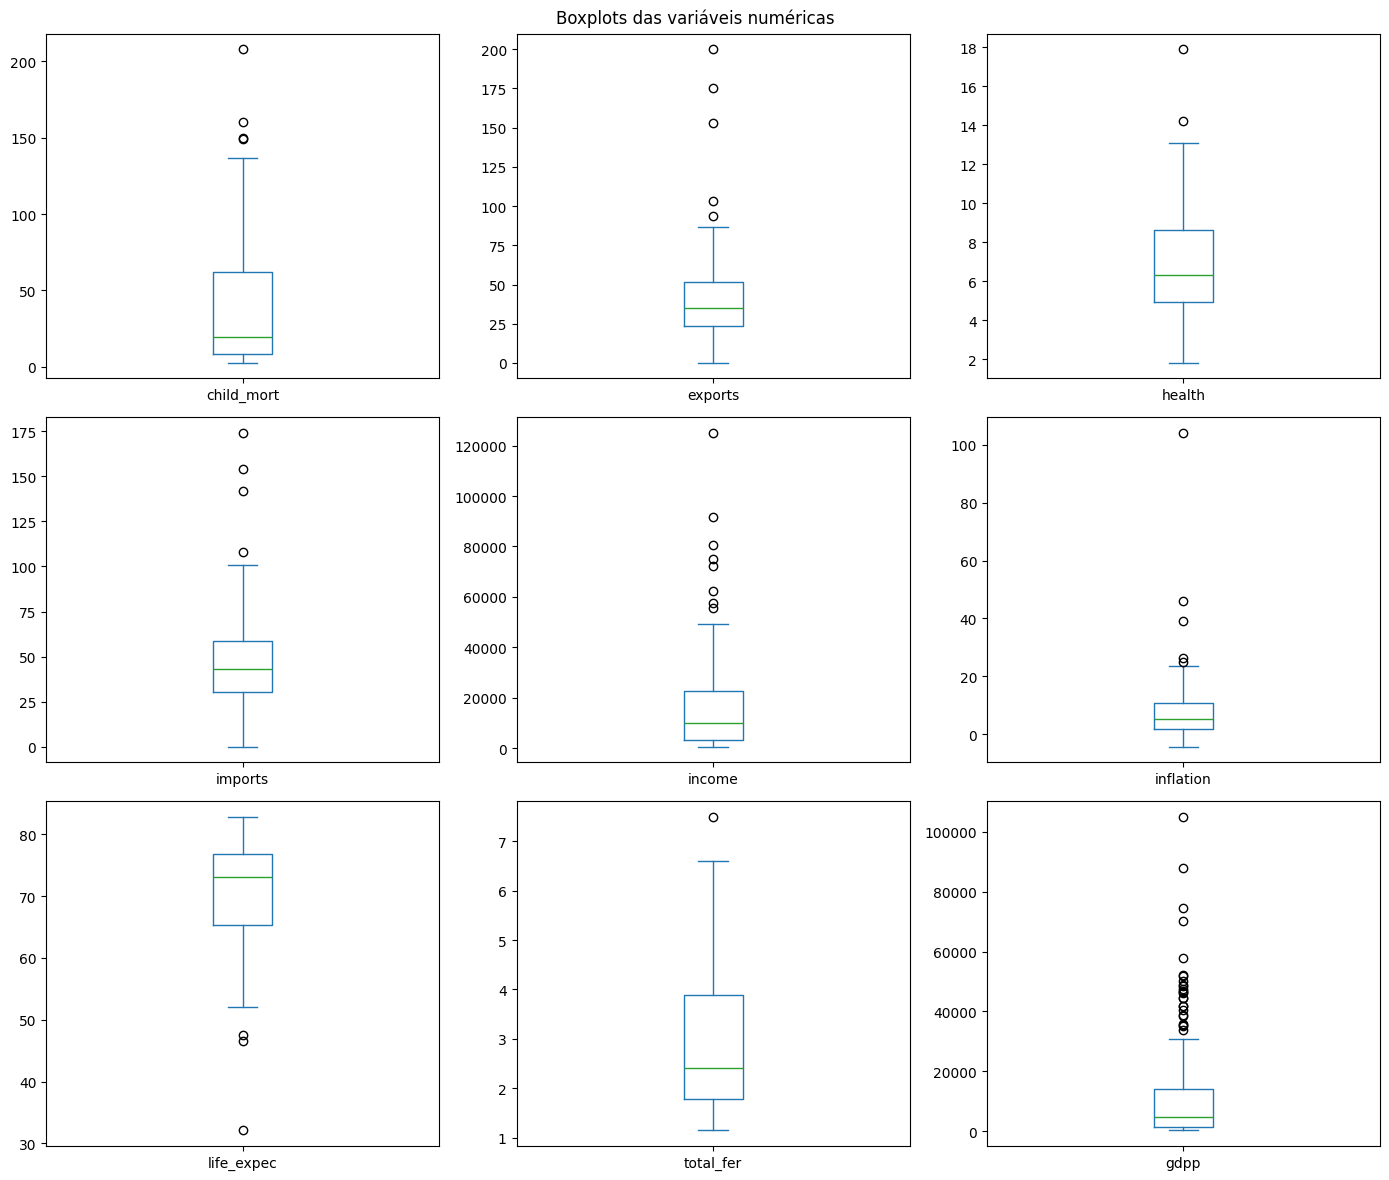

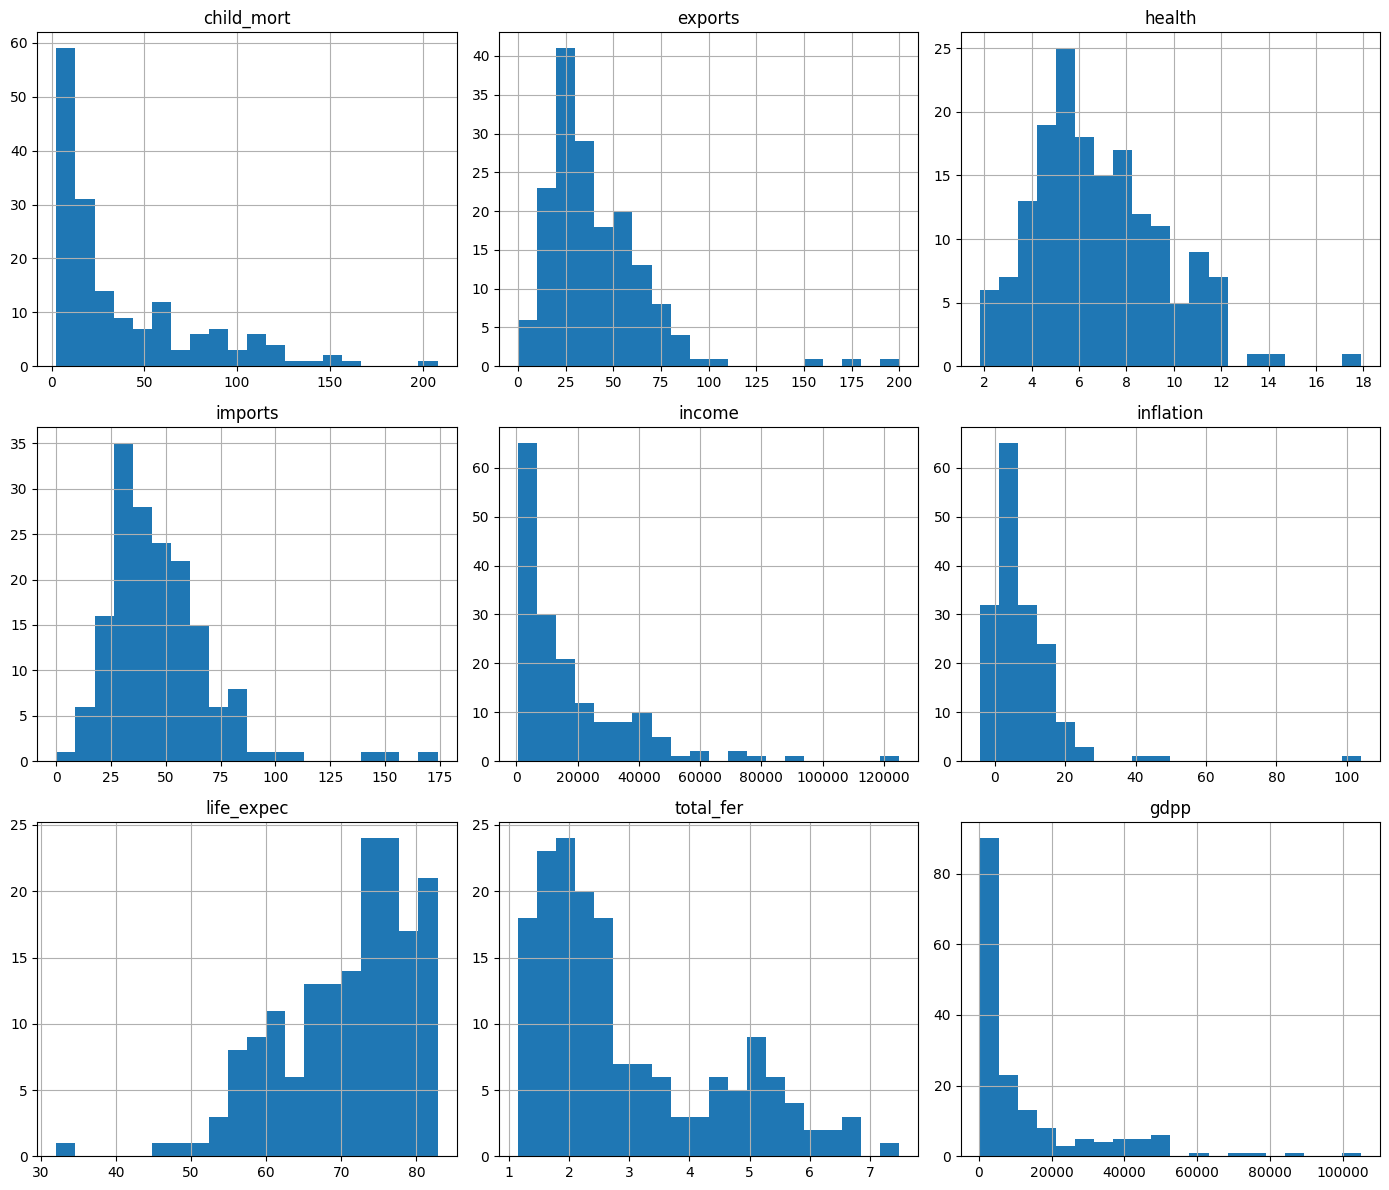

In [4]:
n_countries = df['country'].nunique()
print("Número de países distintos:", n_countries)
import matplotlib.pyplot as plt
import math
numeric_cols = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
print("Colunas numéricas:", numeric_cols)
rows = math.ceil(len(numeric_cols)/3)
df[numeric_cols].plot(kind='box', subplots=True, layout=(rows,3), figsize=(14, 4*rows), sharex=False, sharey=False)
plt.suptitle('Boxplots das variáveis numéricas')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(rows, 3, figsize=(14, 4*rows))
axes = axes.flatten()
for i, c in enumerate(numeric_cols):
    df[c].hist(bins=20, ax=axes[i])
    axes[i].set_title(c)
for j in range(i+1, rows*3):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# Bloco 4 — Pré-processamento: imputação, log e padronização

In [5]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
X = df[numeric_cols].copy()
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=numeric_cols)
skews = X_imp.skew().abs()
log_cols = [c for c in numeric_cols if skews[c] > 1.0 and X_imp[c].min() > 0]
for c in log_cols:
    X_imp[c] = np.log1p(X_imp[c])
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=numeric_cols)
Path("data").mkdir(exist_ok=True)
X_imp.to_csv("data/imputed_country_data.csv", index=False)
X_scaled.to_csv("data/preprocessed_country_data.csv", index=False)
print("Pré-processamento concluído. Shape:", X_scaled.shape)
display(X_scaled.describe().T)

Pré-processamento concluído. Shape: (167, 9)


,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,-8.110611e-17,1.003008,-1.703744,-0.833815,-0.108041,0.938209,2.043054
exports,167.0,-1.007843e-15,1.003008,-5.268313,-0.522801,0.046338,0.618161,2.672748
health,167.0,5.504579e-16,1.003008,-1.827827,-0.692211,-0.181001,0.651541,4.047436
imports,167.0,2.871954e-16,1.003008,-6.839451,-0.569069,0.081980,0.637566,2.633160
income,167.0,3.483574e-16,1.003008,-2.205787,-0.813963,0.074122,0.750115,2.139074
inflation,167.0,-1.063687e-17,1.003008,-1.137852,-0.566641,-0.226950,0.281636,9.129718
life_expec,167.0,3.696311e-16,1.003008,-4.337186,-0.592758,0.286958,0.704258,1.380962
total_fer,167.0,3.044803e-16,1.003008,-1.191250,-0.763902,-0.356431,0.617525,3.009349
gdpp,167.0,-4.095194e-16,1.003008,-2.042565,-0.874036,-0.035578,0.702060,2.047997


# Bloco 5 — K-Means (k=3), centróides e país representante

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = km.fit_predict(X_scaled)
centers = km.cluster_centers_
res = df.copy()
res["kmeans_cluster"] = labels
closest_idx = pairwise_distances_argmin(centers, X_scaled.values)
repr_countries = res.iloc[closest_idx]["country"].tolist()
print("Inércia (SSE):", km.inertia_)
print("Centróides (espaço escalado):")
display(pd.DataFrame(centers, columns=numeric_cols))
for i, (idx, name) in enumerate(zip(closest_idx, repr_countries)):
    print(f"Cluster {i} — país representante:", name)
print("\nMédias no espaço original:")
display(res.groupby("kmeans_cluster")[numeric_cols].mean().round(2))
print("\nMédias no espaço escalado (para interpretar sinais +/-):")
tmp = X_scaled.copy()
tmp["kmeans_cluster"] = labels
display(tmp.groupby("kmeans_cluster")[numeric_cols].mean().round(2))

Inércia (SSE): 771.8527997217961
Centróides (espaço escalado):


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.139996,0.074228,-0.380710,-0.062752,-0.000866,0.213393,0.006733,-0.202310,-0.115396
1,-1.070232,0.519207,0.533332,0.236366,0.959767,-0.500334,0.892742,-0.791921,1.024393
2,1.256835,-0.824606,-0.156289,-0.229459,-1.315581,0.363933,-1.235102,1.392407,-1.231127


Cluster 0 — país representante: Jamaica
Cluster 1 — país representante: South Korea
Cluster 2 — país representante: Tanzania

Médias no espaço original:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
kmeans_cluster,,,,,,,,,
0,29.84,39.30,5.77,43.97,11276.62,10.03,70.62,2.64,5354.06
1,6.89,55.77,8.28,53.60,34576.61,2.51,78.47,1.75,30103.22
2,94.06,23.73,6.39,42.10,2096.81,11.62,59.60,5.05,951.40



Médias no espaço escalado (para interpretar sinais +/-):


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
kmeans_cluster,,,,,,,,,
0,0.14,0.07,-0.38,-0.06,-0.00,0.21,0.01,-0.20,-0.12
1,-1.07,0.52,0.53,0.24,0.96,-0.50,0.89,-0.79,1.02
2,1.26,-0.82,-0.16,-0.23,-1.32,0.36,-1.24,1.39,-1.23


# Bloco 6 — Visualização PCA 2D dos clusters K-Means

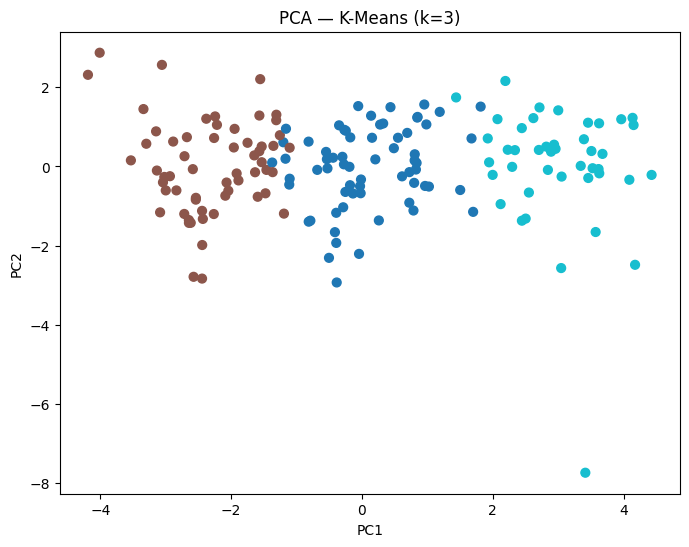

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
p2 = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(p2[:,0], p2[:,1], c=labels, cmap="tab10", s=40)
plt.title("PCA — K-Means (k=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Bloco 7 — Clusterização hierárquica (dendrograma) e comparação com K-Means

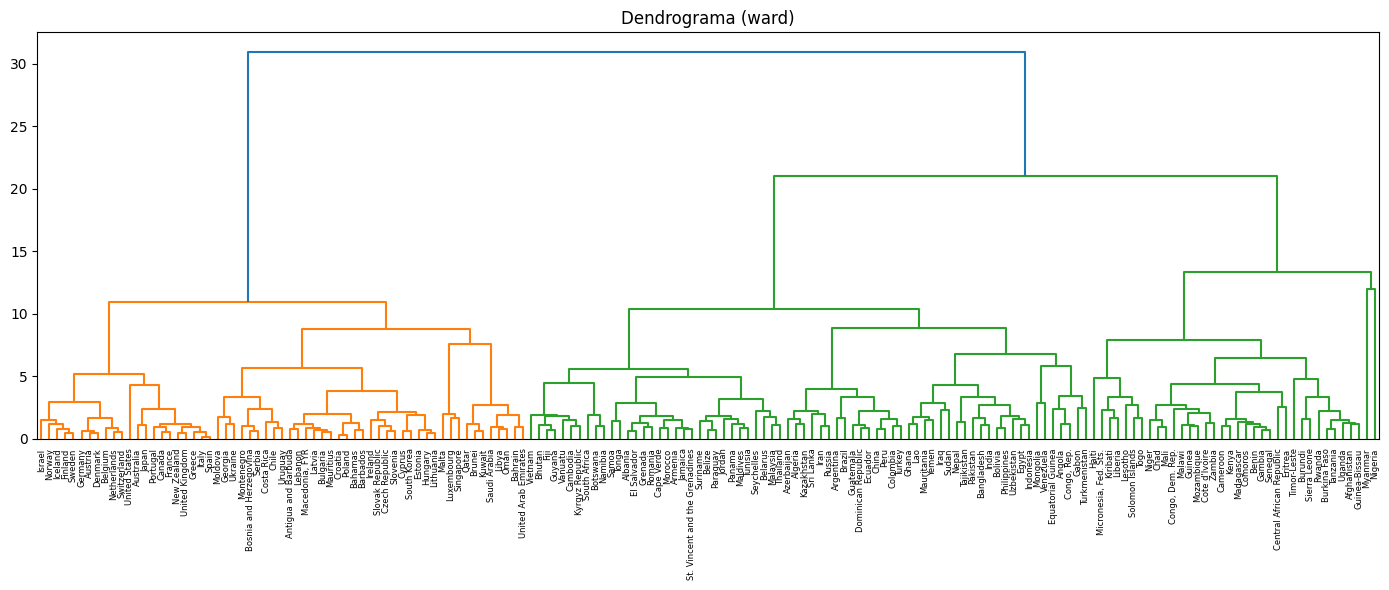

Contingência KMeans × HClust


hcluster,0,1,2
kmeans_cluster,,,
0,6,58,1
1,55,4,0
2,0,8,35


In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(14,6))
dendrogram(Z, labels=res["country"].values, leaf_rotation=90, leaf_font_size=6)
plt.title("Dendrograma (ward)")
plt.tight_layout()
plt.show()
res["hcluster"] = fcluster(Z, t=3, criterion="maxclust") - 1
print("Contingência KMeans × HClust")
display(pd.crosstab(res["kmeans_cluster"], res["hcluster"]))

# Bloco 8 — K-Medoids (com fallback manual)

In [9]:
try:
    from sklearn_extra.cluster import KMedoids
    kmed = KMedoids(n_clusters=3, random_state=42)
    res["kmedoids"] = kmed.fit_predict(X_scaled)
    med_idx = kmed.medoid_indices_
    print("Medoids (índices):", med_idx)
    for i, idx in enumerate(med_idx):
        print(f"Cluster {i} medoid:", res.iloc[idx]["country"])
except Exception as e:
    print("sklearn-extra indisponível, computando medoids manualmente com base no KMeans.")
    med_labels = []
    med_idx_list = []
    for cl in range(3):
        idxs = np.where(res["kmeans_cluster"].values==cl)[0]
        sub = X_scaled.values[idxs]
        dist_sum = np.sum(np.linalg.norm(sub[:,None,:]-sub[None,:,:], axis=2), axis=1)
        med_pos = idxs[np.argmin(dist_sum)]
        med_idx_list.append(med_pos)
        med_labels.extend([cl]*len(idxs))
    res["kmedoids"] = res["kmeans_cluster"]
    print("Medoids (manual, por KMeans):", [res.iloc[i]["country"] for i in med_idx_list])

Medoids (índices): [121  62 147]
Cluster 0 medoid: Poland
Cluster 1 medoid: Guatemala
Cluster 2 medoid: Tanzania


# Bloco 9 — DBSCAN com estimativa de eps por k-distância

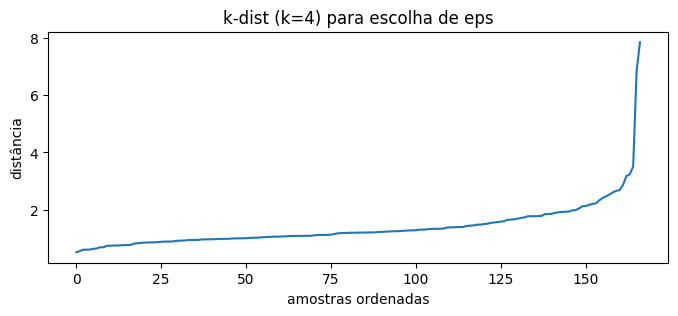

eps sugerido (p90 k-dist): 2.119693516205726
Contagem por rótulo DBSCAN:
 0    158
-1      9
Name: count, dtype: int64


In [10]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
k_for_eps = 4
nn = NearestNeighbors(n_neighbors=k_for_eps)
nn.fit(X_scaled)
dists, _ = nn.kneighbors(X_scaled)
k_dists = np.sort(dists[:, -1])
plt.figure(figsize=(8,3))
plt.plot(k_dists)
plt.title(f"k-dist (k={k_for_eps}) para escolha de eps")
plt.ylabel("distância")
plt.xlabel("amostras ordenadas")
plt.show()
eps = float(np.percentile(k_dists, 90))
print("eps sugerido (p90 k-dist):", eps)
db = DBSCAN(eps=eps, min_samples=k_for_eps)
db_labels = db.fit_predict(X_scaled)
res["dbscan_label"] = db_labels
print("Contagem por rótulo DBSCAN:")
print(pd.Series(db_labels).value_counts())

# Bloco 10 — Interpretação automática dos clusters (K-Means)

In [11]:
g_scaled = X_scaled.copy()
g_scaled["kmeans_cluster"] = res["kmeans_cluster"].values
means_z = g_scaled.groupby("kmeans_cluster")[numeric_cols].mean()
def summarize_cluster(zrow, hi=0.5, lo=-0.5):
    high = [c for c,v in zrow.items() if v >= hi]
    low = [c for c,v in zrow.items() if v <= lo]
    return high, low
print("Resumo automático por cluster (z-médias):")
for cl, zrow in means_z.iterrows():
    hi, lo = summarize_cluster(zrow)
    rep = repr_countries[cl]
    print(f"\nCluster {cl} — representante: {rep}")
    print(" • Altas:", ", ".join(hi) if hi else "—")
    print(" • Baixas:", ", ".join(lo) if lo else "—")
labels_desc = []
for cl, zrow in means_z.iterrows():
    if zrow["life_expec"]>0.5 and zrow["income"]>0.5 and zrow["gdpp"]>0.5 and zrow["child_mort"]<-0.5:
        labels_desc.append("Alto desenvolvimento")
    elif zrow["life_expec"]<-0.5 and zrow["income"]<-0.5 and zrow["gdpp"]<-0.5 and zrow["child_mort"]>0.5:
        labels_desc.append("Baixo desenvolvimento")
    else:
        labels_desc.append("Intermediário")
print("\nRótulos descritivos sugeridos por cluster (ordem 0..2):", labels_desc)

Resumo automático por cluster (z-médias):

Cluster 0 — representante: Jamaica
 • Altas: —
 • Baixas: —

Cluster 1 — representante: South Korea
 • Altas: exports, health, income, life_expec, gdpp
 • Baixas: child_mort, inflation, total_fer

Cluster 2 — representante: Tanzania
 • Altas: child_mort, total_fer
 • Baixas: exports, income, life_expec, gdpp

Rótulos descritivos sugeridos por cluster (ordem 0..2): ['Intermediário', 'Alto desenvolvimento', 'Baixo desenvolvimento']


# Bloco 11 — Salvar artefatos e checklist da rubrica

In [12]:
Path("output").mkdir(exist_ok=True)
res.to_csv("output/cluster_results_with_labels.csv", index=False)
with open("output/rubric_map.json","w") as f:
    json.dump({
        "Part1_requirements_txt": os.path.exists("requirements.txt"),
        "Downloaded_dataset": str(df_path),
        "Count_countries": int(n_countries),
        "EDA_boxplots": True,
        "Preprocessing_impute_scale": True,
        "KMeans_k3": True,
        "Hierarchical": True,
        "Medoids": True,
        "DBSCAN_explained": True,
    }, f, indent=2)
print("Arquivos salvos em output/: cluster_results_with_labels.csv, rubric_map.json")

Arquivos salvos em output/: cluster_results_with_labels.csv, rubric_map.json


# Bloco 12 — Respostas teóricas

## Etapas do K-Means até a convergência

1. **Inicialização:** Escolher k centróides iniciais (exemplo: k-means++).
2. **Atribuição:** Associar cada ponto ao centróide mais próximo (usando distância euclidiana).
3. **Atualização:** Recalcular cada centróide como a média dos pontos atribuídos ao cluster.
4. **Critério de parada:** Repetir atribuição e atualização até que não haja mudança nas atribuições ou a variação total (SSE) não diminua significativamente, ou até atingir o número máximo de iterações.

---

## Algoritmo de K-Médias modificado para usar medóides (representantes reais)

1. **Inicialização:** Escolher k medóides (pontos reais do conjunto de dados).
2. **Atribuição:** Associar cada ponto ao medóide mais próximo.
3. **Atualização:** Para cada cluster, escolher como novo medóide o ponto do cluster que minimiza a soma das distâncias a todos os demais pontos do cluster (não a média).
4. **Critério de parada:** Parar quando os medóides não mudam ou a soma das distâncias intra-cluster não melhora.

> Obs.: Esse é o algoritmo K-Medoids (exemplo: PAM). Ele garante que o representante é sempre um ponto real do conjunto.

---

## Por que K-Means é sensível a outliers?

O centróide é calculado como a média aritmética dos pontos do cluster. Um ponto extremo (outlier) pode deslocar fortemente essa média, alterando a posição do centróide, as fronteiras dos clusters e até “puxando” pontos que não deveriam pertencer ao cluster.

---

## Por que DBSCAN é mais robusto a outliers?

DBSCAN define clusters por densidade: regiões com densidade acima de um limiar (eps, min_samples) formam clusters; pontos isolados ou raros, que não estão conectados por densidade, são rotulados como ruído (-1). Assim, outliers não afetam “centros” de clusters e apenas ficam fora de qualquer cluster.